<a href="https://colab.research.google.com/github/ugursirvermez/PyTorch_Education/blob/main/05_pytorch_cv_cnn_model_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#CNN Yüksek Seviye Model Tasarlama: Model_2

##Modelin Aşamalarına Test
Modelin aşamalarını test etmek için yazılan kodlar, pasifler.

In [1]:
#---------------------------------------------------------------TEST ETMEK İÇİN----------------------------------------------------------
'''
images = torch.randn(size=(32,3,64,64)) #resimleri batch=32, color_channel=3, size= 64x64
test_image = images[0] #Örnek resim

#nn.Conv2d() -> Bunun üzerine gideceğiz.
conv_layer = nn.Conv2d(in_channels=3, out_channels=10, kernel_size=(3,3), stride=1, padding=0)
#Convolutional katmana doğru veriyi geçirme
conv_output = conv_layer(test_image.unsqueeze(0)) #hata olmasın diye 3 boyutlu veriyi unsqueeze ile 4 boyutlu yaptık.

#nn.Maxpool2d -> Conventional sonrası kullanılan katman
max_pool_layer = nn.MaxPool2d(kernel_size=2)
#conv_layer'dan veriyi geçirelim.
test_image_through_conv = conv_layer(test_image.unsqueeze(dim=0))
#max pool layer'a veriyi geçirelim.
test_image_through_conv_and_max_pool = max_pool_layer(test_image_through_conv)
'''
print("Önceki test kodları")
#---------------------------------------------------------------TEST BURADA BITIYOR------------------------------------------------------

Önceki test kodları


#MODEL_2
İçinde CNN, Pooling ve Sınıflandırma var.

In [2]:
import torch
from torch import nn
import torchvision
from torchvision import datasets
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.transforms import ToTensor
from torch import nn
from timeit import default_timer as timer # Zaman ayarları için var.
from tqdm.auto import tqdm #Eğitimi işlem barında göstermek için kullanacağız. Progess bar kütüphanesi
import requests
from pathlib import Path
if Path("helper_functions.py").is_file():
	print("helper_functions.py varsa indirme")
else:
	print("helper_function.py indir")
	request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
	with open("helper_functions.py", "wb") as f: #aynı dosyayı aç ve içeriğini yaz.
		f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary, accuracy_fn #Daha önceden yazdığımız kodlardan alınma aslında.
#-------------------------------------------------------KÜTÜPHANELER--------------------------------------------------------------------
#Device tanımlama
device = "cuda" if torch.cuda.is_available() else "cpu"

#CNN Oluşturma
class FashionMNISTModelV2(nn.Module): #TinyVGG modeli yapacağız.
	def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
		super().__init__()
		#CNN için Conv2d kullanıyoruz. TinyVGG'de iki tane Conv modeli kullanıldığı için 2 kullandık.
		self.conv_block_1 = nn.Sequential(#kernel_size, stride ve padding bizim belirlediğimiz değerlerdir. Bunu anlamak için: https://poloclub.github.io/cnn-explainer/
												nn.Conv2d(in_channels = input_shape, out_channels = hidden_units, kernel_size=3, stride=1, padding=1),
												nn.ReLU(),
												nn.Conv2d(in_channels = hidden_units, out_channels = hidden_units, kernel_size=3, stride=1, padding=1),
												nn.ReLU(),
												nn.MaxPool2d(kernel_size=2) #Pooling Layer
												)
		#Şimdi 2.CNN katmanını kuruyoruz.
		self.conv_block_2 = nn.Sequential(
												nn.Conv2d(in_channels = hidden_units, out_channels = hidden_units, kernel_size=3, stride=1, padding=1),
												nn.ReLU(),
												nn.Conv2d(in_channels = hidden_units, out_channels = hidden_units, kernel_size=3, stride=1, padding=1),
												nn.ReLU(),
												nn.MaxPool2d(kernel_size=2)
												)
		#Şimdi doğrusal modele çıkarmak için yaptığımız self.Linear modeli uygulayacağız.
		self.classifier= nn.Sequential(nn.Flatten(),
																		 nn.Linear(in_features = hidden_units *7 *7, out_features = output_shape),
																		 nn.ReLU()) # doğrusal olmayan çıktı için ReLU gereklidir.

	def forward(self,x):
		x = self.conv_block_1(x)
		#print(f"Conv_1:{x.shape}") # ne oluyor bir bakarız.
		x = self.conv_block_2(x)
		#print(f"Conv_2:{x.shape}")
		x = self.classifier(x)
		return x # zaten output shape olacak.
#---------------------------------------------------------------MODEL BURADA BITIYOR------------------------------------------------------
#---------------------------------------MODEL_1 HAZIRLADIGIMIZ FONKSIYONLAR---------------------------------------------------------------
#TIMER KODU
#Zamana bağlı eğitimi yazdırmak için var.
def print_train_time(start: float, end: float, device: torch.device = None):
	total_time = end - start
	print(f"Eğitim Zamanı: {device}: {total_time} Saniye")
	return total_time

#TRAIN_STEP ve TEST_STEP FONKSİYONLARI
#TRAIN_STEP
def train_step(model: torch.nn.Module, data_loader: torch.utils.data.DataLoader, loss_fn: torch.nn.Module,
							 optimizer: torch.optim.Optimizer, accuracy_fn, device: torch.device = device):

	train_loss, train_acc = 0,0

	#Eğitime başlıyoruz.
	model.train()

	#Döngü içinde döngü yapalım.
	for batch, (X, y) in enumerate(data_loader): #X -> Image, y -> Label
		#Cihazları ayarlayalım.
		X, y = X.to(device), y.to(device)

		y_pred = model_2(X) #Forward edilecek.

		#Loss'u her batch için yapacağız.
		loss = loss_fn(y_pred, y)
		train_loss += loss # eğitim kaybını kümeleyelim.
		train_acc = accuracy_fn(y_true = y, y_pred = y_pred.argmax(dim=1))

		#Batch için Optimizer
		optimizer.zero_grad()
		#Loss Backward
		loss.backward()
		#Optimizer step
		optimizer.step()

	#Train_dataloader'daki kayba bakalım.
	train_loss /= len (data_loader)
	train_acc /= len(data_loader)
	print(f"Train Loss: {train_loss: .5f} | Train Acc: {train_acc: .2f}")

#TEST_STEP
def test_step(model: torch.nn.Module, data_loader: torch.utils.data.DataLoader, loss_fn: torch.nn.Module,
							optimizer: torch.optim.Optimizer, accuracy_fn, device: torch.device = device):

	test_loss, test_acc = 0, 0
	model.eval()
	# inference modu çalıştıralım.
	with torch.inference_mode():
		for X_test, y_test in data_loader:

			X_test, y_test = X_test.to(device), y_test.to(device)

			test_pred = model(X_test)

			test_loss += loss_fn(test_pred, y_test)
			test_acc += accuracy_fn(y_true = y_test, y_pred = test_pred.argmax(dim=1))

		test_loss /= len(data_loader)
		test_acc /= len(data_loader)
		print(f"Test Loss: {test_loss: .5f} | Test Acc: {test_acc:.2f}%\n")

#Model_2.eval() şeyleri
def eval_model(model: torch.nn.Module, data_loader: torch.utils.data.DataLoader, loss_fn: torch.nn.Module, accuracy_fn):
    loss, acc = 0, 0
    model.eval()
    with torch.inference_mode():
        for X, y in data_loader:
            # Make predictions with the model
            y_pred = model(X)

            # Accumulate the loss and accuracy values per batch
            loss += loss_fn(y_pred, y)
            acc += accuracy_fn(y_true=y,
                                y_pred=y_pred.argmax(dim=1)) # For accuracy, need the prediction labels (logits -> pred_prob -> pred_labels)

        # Scale loss and acc to find the average loss/acc per batch
        loss /= len(data_loader)
        acc /= len(data_loader)

    return {"model_name": model.__class__.__name__, # only works when model was created with a class
            "model_loss": loss.item(),
            "model_acc": acc}


#---------------------------------------MODEL_1 HAZIRLADIGIMIZ FONKSIYONLAR BITTI----------------------------------------------------------

#TRAIN_DATA
train_data = datasets.FashionMNIST(root="data", train=True, download=True, transform = torchvision.transforms.ToTensor(), target_transform = None)

#TEST_DATA
test_data = datasets.FashionMNIST(root="data", train=False, download=True, transform = torchvision.transforms.ToTensor(), target_transform = None)
#TRAIN DATA CLASS
class_names = train_data.classes

#DATALOADER
BATCH_SIZE = 32

#Veri setini yenilemeye çevirelim. Train_Data
train_dataloader = DataLoader(dataset = train_data, batch_size = BATCH_SIZE, shuffle = True)
#Test_Data
test_dataloader = DataLoader(dataset = test_data, batch_size = BATCH_SIZE, shuffle = False)
#Eğitilmiş verilerin içinde ne var?
train_features_batch , train_labels_batch = next(iter(train_dataloader))

#MODELİ ÇALIŞTIRALIM!
torch.manual_seed(42)
torch.cuda.manual_seed(42)
model_2 = FashionMNISTModelV2(input_shape = 1, hidden_units= 10, output_shape=len(class_names)).to(device) #Model tanımlandı.

#rastgele image olusturalım.
rand_image_tensor = torch.randn(size=(1, 28, 28))

#Model_2'ye sokalım.
#model_2(rand_image_tensor.unsqueeze(0).to(device))

#Loss ve Optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_2.parameters(), lr=0.1)

#Training/Testing Fonksiyonları
#Timer start
Train_Start_timer = timer()

#dongu
epochs = 3
for epoch in tqdm(range(epochs)):
	print(f"Epoch:{epoch}\n----")
	#Train uygula
	train_step(model= model_2, data_loader = train_dataloader, loss_fn = loss_fn, optimizer=optimizer, accuracy_fn= accuracy_fn, device = device)
	#Test Uygula
	test_step(model= model_2, data_loader = test_dataloader, loss_fn = loss_fn, optimizer=optimizer, accuracy_fn= accuracy_fn, device = device)

#Timer End
Train_End_timer = timer()
#Timer Calc
total_train_time_model_2 = print_train_time(Train_Start_timer, Train_End_timer, device)

#Değerlendirme ve Sonuç yazdırma
model_2_results = eval_model(model=model_2, data_loader = test_dataloader, loss_fn = loss_fn, accuracy_fn = accuracy_fn)
print("İşlemler Bitti!")

helper_function.py indir


100%|██████████| 26421880/26421880 [00:01<00:00, 15139373.78it/s]


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 268646.84it/s]


Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:05<00:00, 873730.99it/s] 


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 8863824.71it/s]


Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/3 [00:00<?, ?it/s]

Epoch:0
----
Train Loss:  0.89260 | Train Acc:  0.04
Test Loss:  0.62134 | Test Acc: 81.85%

Epoch:1
----
Train Loss:  0.56656 | Train Acc:  0.04
Test Loss:  0.55760 | Test Acc: 82.82%

Epoch:2
----
Train Loss:  0.52327 | Train Acc:  0.05
Test Loss:  0.54754 | Test Acc: 82.85%

Eğitim Zamanı: cpu: 185.219049616 Saniye
İşlemler Bitti!


Yukarıdaki veri sonucu manual_seed'i tekrar yapıp yapmamaya göre değişiklik gösterecektir. Normalde bir daha seed yaptığımda % 80 en az başarı sağlıyor.

## Model_2: Rastgele Görsel Tahminlerle Sonuçları Değerlendirme

In [3]:
#Model_2'den görsel sonuçlar üretmek için rastgele verileri değerlendireceğiz.
def make_predictions(model: torch.nn.Module, data: list, device: torch.device = device):
	pred_probs = [] # -> liste oluşturup otahmin olasılıklarına bakacağız.
	model.eval()
	model.to(device)
	with torch.inference_mode():
		for sample in data:
			#Örnek hazırlayalım.
			sample = torch.unsqueeze(sample, dim=0).to(device)
			#Forward Edelim.
			pred_logit = model(sample)
			#Olasılık tahminlerini topla)
			pred_prob = torch.softmax(pred_logit.squeeze(), dim=0)
			#GPU'da işlemlerin yapılacağını belirtme -> diziye yazdırma
			pred_probs.append(pred_prob.cpu())

	return torch.stack(pred_probs) #diziyi torch.stack ile dışarıdan değer döndürme.

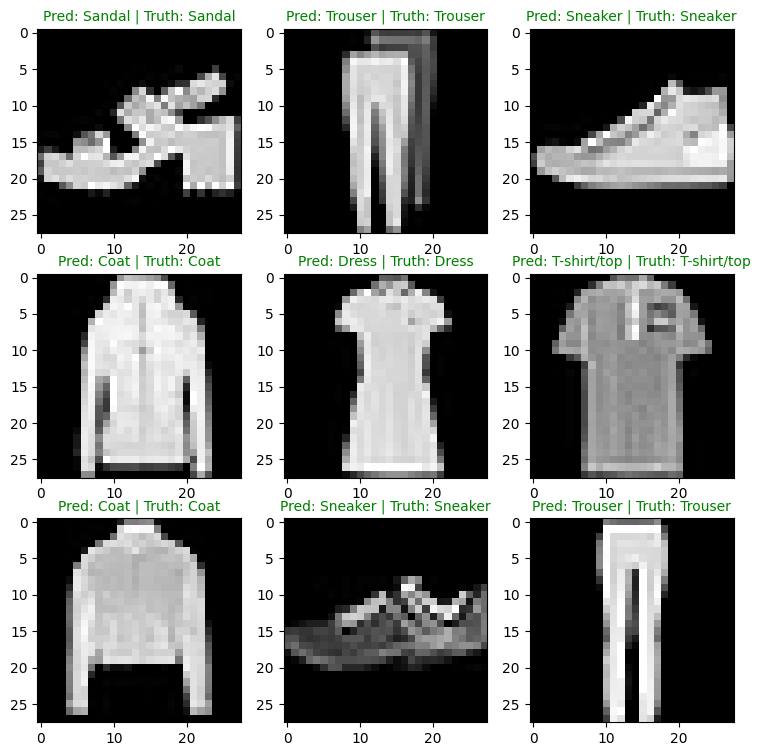

In [4]:
import random #Rastgele kütüphanesi Python'dan gelen kütüphanedir.
import matplotlib.pyplot as plt

random.seed(42) #Rastgele veri üretme
test_samples = [] #test listesi
test_labels = [] #test etiket listesi

for sample, label in random.sample(list(test_data), k=9): #3'e 3 liste olacağı için k=9
	test_samples.append(sample)
	test_labels.append(label)

#görselleme Sadece bir tanesi
#plt.imshow(test_samples[0].squeeze(), cmap="gray")
#plt.title(class_names[test_labels[0]])

#Fonskiyonu çağırma
pred_probs = make_predictions(model=model_2, data = test_samples)
#Tahmin olasılıklarını etiketleyelim.
pred_classes = pred_probs.argmax(dim=1)
#Tahminleri Görselleştirelim
plt.figure(figsize=(9,9))
# k = 9 bu yüzden
nrows = 3
ncols = 3

#sample toplayalım.
for i, sample in enumerate(test_samples):

	plt.subplot(nrows, ncols, i+1) # alt bir çizim yapılacak.
	plt.imshow(sample.squeeze(), cmap="gray") #Sample çizdir.
	pred_label = class_names[pred_classes[i]] #etiketleri yerleştir.
	truth_label = class_names[test_labels[i]] # text metni olarak yazdır.
	title_text = f"Pred: {pred_label} | Truth: {truth_label}" #başlığı yazdır.

	#Eğer sonuçlar aynıysa yeşil, değilse kırmızı yaz.
	if pred_label == truth_label:
		plt.title(title_text, fontsize=10, c="g")
	else:
		plt.title(title_test, fontsize=10, c="r")


##Model_2: Confusion Matrix (Hata Matrisi) Oluşturma

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 869.2/869.2 kB 14.7 MB/s eta 0:00:00
Kutuphaneler yuklu: 0.23.1


Tahmin yürütme:   0%|          | 0/313 [00:00<?, ?it/s]

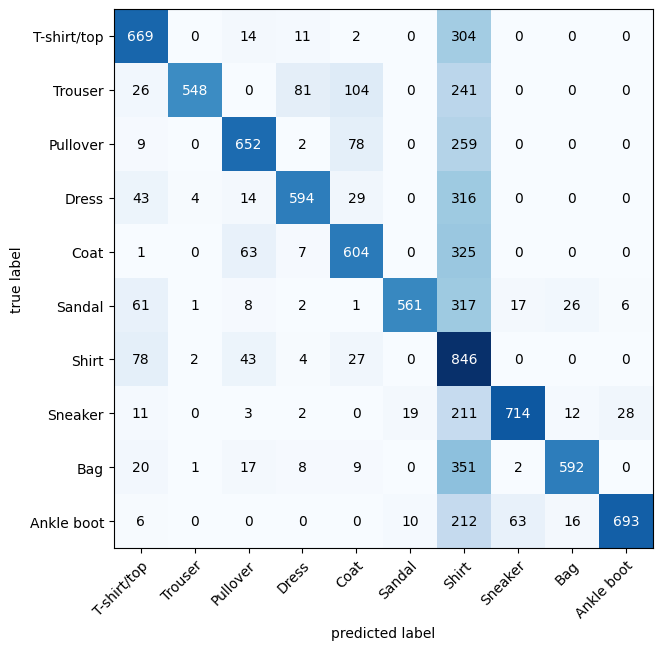

In [5]:
# Confusion Matrix oluşturma
from tqdm.auto import tqdm
try: #mlxtend yüklü olmayabilir.
	import torchmetrics, mlxtend
	print(f"Kutuphaneler yuklu: {mlxtend.__version__}")
	assert int(mlxtend.__version__.split(".")[1] >= 19, "mlxtend 19.0 üstü olmalı...")
except:
	!pip install -q torchmetrics -U mlxtend
	import torchmetrics, mlxtend
	print(f"Kutuphaneler yuklu: {mlxtend.__version__}")

from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

#Eğitilmiş modelden tahmin alma
y_preds =[]
model_2.eval()
with torch.inference_mode():
	for X, y in tqdm(test_dataloader, desc="Tahmin yürütme"):
		X,y = X.to(device), y.to(device)
		#Forward etme
		y_logit = model_2(X)
		#logit -> olasılık tahminlerine -> etiketlere dönüştürme
		y_pred = torch.softmax(y_logit.squeeze(), dim=0).argmax(dim=1)
		#CPU ile çalıştırma
		y_preds.append(y_pred.cpu())

#Tahmin tensörünü elde etme
y_pred_tensor = torch.cat(y_preds)

#Hataları bulalım.
confmat = ConfusionMatrix(task="multiclass", num_classes = len(class_names))
confmat_tensor = confmat(preds = y_pred_tensor, target=test_data.targets)

# mlxtend ile hata matrisini sunma
fig, ax = plot_confusion_matrix(conf_mat = confmat_tensor.numpy(), class_names = class_names, figsize=(10,7))

##MODEL_2 Kaydetme ve Yükleme

In [7]:
from pathlib import Path

#Modelin kaydedileceği dosya yolunu belirleyelim.
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

#Modelin kaydedileceği yol ve ismi belirleyelim.
MODEL_NAME = "Model_2.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

#Modeli kaydetme işlemini yapalım.
print(f"Dosyanız {MODEL_SAVE_PATH} yoluna, {MODEL_NAME} ismiyle başarıyla kaydedilmiştir.")
torch.save(obj=model_2.state_dict(), f=MODEL_SAVE_PATH)

Dosyanız models/Model_2.pth yoluna, Model_2.pth ismiyle başarıyla kaydedilmiştir.


In [8]:
#Instance yani nesne türetme işlemi yapalım.
torch.manual_seed(42)
loaded_model_2 = FashionMNISTModelV2(input_shape=1, hidden_units=10, output_shape=len(class_names))

#Mevcut kaydedilmiş modeli yükelyelim.
loaded_model_2.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

#Modeli cihaza yükleme
loaded_model_2.to(device)

<ipython-input-8-10464e68204b>:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model_2.load_state_dict(torch.load(f=MODEL_SAVE_PATH))


FashionMNISTModelV2(
  (conv_block_1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
    (2): ReLU()
  )
)

In [9]:
#Loaded_model_2'nin sonuçlarını kontrol edelim.
torch.manual_seed(42)

loaded_model_2_results = eval_model(model = loaded_model_2,
																		data_loader = test_dataloader,
																		loss_fn = loss_fn,
																		accuracy_fn = accuracy_fn)

#Model sonuçlarının diğeri ile durumunu karşılaştırabiliriz.
torch.isclose(torch.tensor(model_2_results["model_loss"]),
													 torch.tensor(loaded_model_2_results["model_loss"]),
													 atol=1e-02) #atol -> Tolerans miktarı ne kadar olsun? logaritma olarak düşünülmeli.

tensor(True)